# Get the Labels

In [4]:
import numpy as np
from astropy.io import fits # You might need to pip install this
import pylab as plt # only needed for verification

In [5]:
path_labels = "./labels.fits"
allstar = fits.open(path_labels)

(5.0, 0.0)

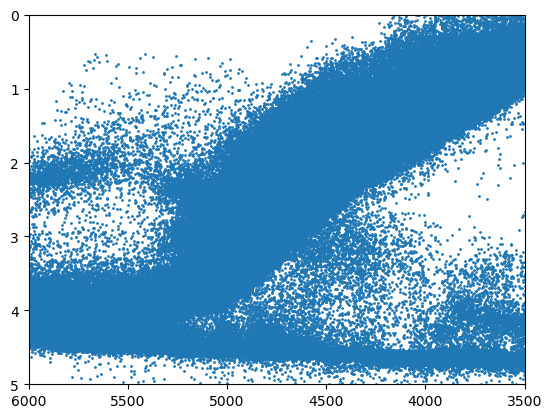

In [6]:
# the labels are in an enormous table in element [1] of this FITS file
labels = allstar[1].data
plt.scatter(labels['TEFF'], labels['LOGG'], s=1)
plt.xlim(6000, 3500)
plt.ylim(5, 0)

In [7]:
# make a reasonable red-giant-branch sample
RGB = True
RGB = np.logical_and(RGB, labels['TEFF'] > 3500.)
RGB = np.logical_and(RGB, labels['TEFF'] < 5400.)
RGB = np.logical_and(RGB, labels['LOGG'] < 3.0)
RGB = np.logical_and(RGB, labels['LOGG'] > 0.0)
RGB = np.logical_and(RGB, labels['H'] < 10.5)
print(np.sum(RGB))

145991


In [ ]:
# make a plot that an astronomer likes to see
RGB_labels = labels[RGB]
plt.scatter(RGB_labels['TEFF'], RGB_labels['LOGG'], c=RGB_labels['FE_H'], s=1)
plt.xlim(5400, 3500)
plt.xlabel("effective temperature")
plt.ylim(3., 0.)
plt.ylabel("log10 surface gravity")
plt.colorbar(label="metallicity")

In [ ]:
# make train, validation, and test data sets
rng = np.random.default_rng(17)
N_RGB = len(RGB_labels)
N_train, N_valid, N_test = 1024, 256, 512
I = rng.permutation(N_RGB)
I_train = I[0:N_train]
I_valid = I[N_train:N_train+N_valid]
I_test = I[N_train+N_valid:N_train+N_valid+N_test]

train_labels = RGB_labels[I_train]
valid_labels = RGB_labels[I_valid]
test_labels = RGB_labels[I_test]
print(len(train_labels), len(valid_labels), len(test_labels))

Here how you get `LOGG`

In [ ]:
train_labels_logg = train_labels['LOGG']
valid_labels_logg = valid_labels['LOGG']
print(train_labels_logg.shape) # (num_spectra, 1)
train_labels_logg

# Get the Features

In [ ]:
import numpy as np
from matplotlib import pyplot as plt

In [ ]:
train_features = np.load('./train_features.npy')
valid_features = np.load('./valid_features.npy')
test_features = np.load('./test_features.npy')
for i in range(10):
    plt.plot(train_features[i] + i)

# MLP method

### import pytorch

In [ ]:
import torch
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
import matplotlib.pyplot as plt

print(torch.__version__)

### building the model

In [ ]:
class MLP(nn.Module):
    def __init__(self, input_size, hidden_size, hidden_size2,hidden_size3, output_size):
        super(MLP, self).__init__()
        self.input = nn.Linear(input_size, hidden_size)
        self.hidden = nn.Linear(hidden_size, hidden_size2)
        self.hidden2 = nn.Linear(hidden_size2, hidden_size3)
        self.output = nn.Linear(hidden_size3, output_size)
        self.activation = nn.LeakyReLU()

    
    def forward(self, x):
        '''
        Args
            x (torch.Tensor): Shape (batch_size, 8000)
        '''
        out = self.input(x) # (batch_size, hidden_size)
        out = self.activation(out) 
        out = self.hidden(out) # (batch_size, hidden_size2)
        out = self.activation(out)
        out = self.hidden2(out)
        out = self.activation(out)
        out = self.output(out) # (batch_size, 1) \neq (batch_size)
        return out

### import data

In [ ]:
mean = train_features.mean(axis=0)
print(mean.shape)
std  = train_features.std(axis=0) + 1e-8

train_features = (train_features - mean[None, :]) / std
valid_features = (valid_features - mean[None, :]) / std

In [ ]:
print(np.shape(train_features))
train_features_tensor = torch.from_numpy(train_features).float()
valid_features_tensor = torch.from_numpy(valid_features).float()

In [ ]:
from torch.utils.data import TensorDataset, DataLoader

train_dataset = TensorDataset(train_features_tensor, train_labels_logg)
val_dataset   = TensorDataset(valid_features_tensor, valid_labels_logg)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)

In [ ]:
model1 = MLP(input_size=8575, hidden_size=128*2, hidden_size2=128*2, hidden_size3=128*2, output_size=1)
model1(train_features_tensor).shape

### training: finding the parameters

In [ ]:
def run_optimization(num_epochs: int, optimizer, criterion):
    model1.train() # Enable dropout, batch norm training mode, etc.
    for epoch in range(num_epochs):
        total_loss = 0
        for batch_idx, (data, target) in enumerate(train_loader):
            optimizer.zero_grad()   # Zero gradients from previous step
            
            output = model1(data) # Forward pass
            loss = criterion(output.squeeze(), target) # Compute loss ((batch_size, 1) \times (batch_size))
            
            loss.backward()         # Backpropagation
            optimizer.step()        # Update weights
            
            total_loss += loss.item()
        
        avg_loss = total_loss / len(train_loader)
        print(f"Epoch {epoch+1}/{num_epochs}, Loss: {avg_loss:.4f}")

In [ ]:
# Optimizer
optimizer = optim.Adam(model1.parameters(), lr=1e-4)
# Loss Funciton
criterion = nn.MSELoss()
run_optimization(num_epochs=100, optimizer=optimizer, criterion=criterion)

### trainning fit

In [ ]:
model1.eval()

with torch.no_grad():   # IMPORTANT
    x, y = train_dataset.tensors   # unpack tensors
    y_pred_test = model1(x).squeeze()

# If output is (N,1), flatten for plotting
y_pred_test = y_pred_test.squeeze()

plt.figure(figsize=(6,6))

plt.plot(y, 'o', markersize=3, label='True')
plt.plot(y_pred_test, '-', label='Prediction')

plt.legend()
plt.xlabel("Sample index")
plt.ylabel("Value")
plt.show()

### validation

In [ ]:
model1.eval()

with torch.no_grad():   # IMPORTANT
    x_val, y_val = val_dataset.tensors   # unpack tensors
    y_pred_valid = model1(x_val)

# If output is (N,1), flatten for plotting
y_pred_valid = y_pred_test.squeeze()

plt.figure(figsize=(6,6))

plt.plot(y_val, 'o', markersize=3, label='True')
plt.plot(y_pred_valid, '-', label='Prediction')

plt.legend()
plt.xlabel("Sample index")
plt.ylabel("Value")
plt.show()

## KNN method

In [ ]:
from sklearn.neighbors import KNeighborsClassifier  # or KNeighborsRegressor

model2 = KNeighborsClassifier(n_neighbors=5)
model2.fit(train_features, train_labels_logg)

In [ ]:
y_pred = model2.predict(valid_features)

In [ ]:
plt.figure(figsize=(6,6))

plt.plot(valid_labels_logg, 'o', markersize=3, label='True')
plt.plot(y_pred, '-', label='Prediction')

plt.legend()
plt.xlabel("Sample index")
plt.ylabel("Value")
plt.show()

## Linear Regression

In [ ]:
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

In [ ]:
model3 = LinearRegression()
model3.fit(train_features, train_labels_logg)

### validation

In [ ]:
y_pred_LR = model3.predict(valid_features)

In [ ]:
plt.figure(figsize=(6,6))

plt.plot(valid_labels_logg, 'o', markersize=3, label='True')
plt.plot(y_pred_LR, '-', label='Prediction')

plt.legend()
plt.xlabel("Sample index")
plt.ylabel("Value")
plt.show()

## Running 3 models on the test data

In [ ]:
y_pred_LR_test = model3.predict(test_features)
y_pred_KNN_test = model2.predict(test_features)
y_pred_MLP_test = model1.predict(test_features)

plt.figure(figsize=(6,6))

plt.plot(test_labels_logg, 'o', markersize=3, label='True')
plt.plot(y_pred_LR_test, '-', color='red',label='Prediction')
plt.plot(y_pred_KNN_test, '-', color='blue',label='Prediction')
plt.plot(y_pred_MLP_test, '-', color='green',label='Prediction')


plt.legend()
plt.xlabel("Sample index")
plt.ylabel("Value")
plt.show()

### justify choice of hyperparameters

### For the KNN & MLP, rerun the algorithm but with various RNG seeds. Do you converge to a similar answer?